In [2]:
# Basic imports first
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

print("Basic libraries imported successfully!")

Basic libraries imported successfully!


In [4]:
# Import TensorFlow and ML libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print("All libraries imported successfully!")

TensorFlow version: 2.19.0
All libraries imported successfully!


## Data Loading and Exploration

Weather classes found: ['Cloudy', 'Rain', 'Shine', 'Sunrise']

Number of images per class:
Cloudy: 300 images
Rain: 215 images
Shine: 253 images
Sunrise: 357 images


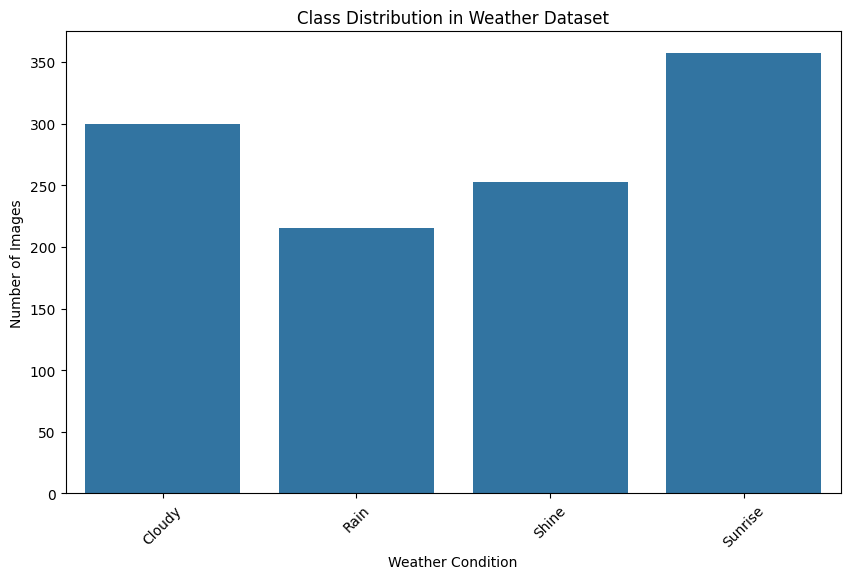

In [5]:
# Define dataset path
dataset_path = 'weather_dataset/'

# Get class names from folder structure - filter out files like .DS_Store
class_names = [item for item in sorted(os.listdir(dataset_path)) 
               if os.path.isdir(os.path.join(dataset_path, item))]
print("Weather classes found:", class_names)

# Count number of images per class
# Count number of images per class
class_counts = {}
for class_name in class_names:
    class_dir = os.path.join(dataset_path, class_name)
    try:
        class_counts[class_name] = len(os.listdir(class_dir))
    except NotADirectoryError:
        pass
# Display class distribution
print("\nNumber of images per class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Class Distribution in Weather Dataset')
plt.xlabel('Weather Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

## Sample Image Visualization

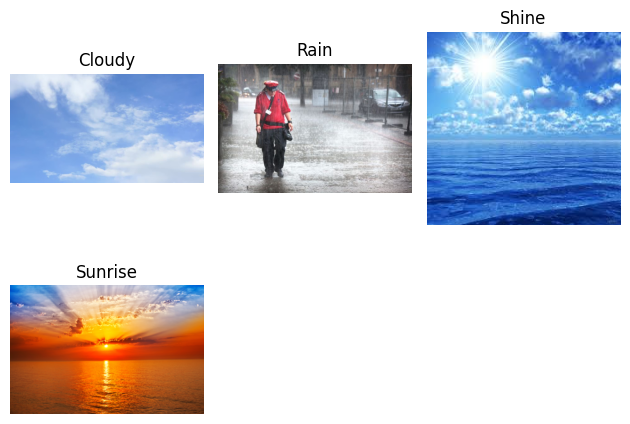

In [9]:
# Display sample images from each class
# Get first image in each class
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(dataset_path, class_name)
    image_files = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png', '.jpeg', '.gif', '.bmp'))]
    if image_files:
        sample_image = image_files[0]  # Get first image
        img_path = os.path.join(class_dir, sample_image)
        img = Image.open(img_path)
    else:
        print(f"No images found in class {class_name}")
    
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Data Processing

In [6]:
# Define constants
IMAGE_SIZE = (128, 128)  # As recommended in the MVP guide
BATCH_SIZE = 32
TEST_SIZE = 0.2
VAL_SIZE = 0.2  # Of the remaining training data after test split

# Create ImageDataGenerator for data augmentation (as mentioned in MVP)
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=VAL_SIZE  # Will use this for validation split
)

# For test data, we only need rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Create train, validation, and test generators
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=42
)

# For test data, we'll manually split the data
# First get all file paths and labels
file_paths = []
labels = []
for class_name in class_names:
    class_dir = os.path.join(dataset_path, class_name)
    for img_file in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, img_file))
        labels.append(class_name)

# Split into train and test
train_files, test_files, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=TEST_SIZE, random_state=42, stratify=labels
)

# Create a DataFrame for test data
test_df = pd.DataFrame({
    'filename': test_files,
    'class': test_labels
})

# Create test generator
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Print class indices to verify consistency
print("\nClass indices across all generators:")
print("Train generator:", train_generator.class_indices)
print("Validation generator:", val_generator.class_indices)
print("Test generator:", test_generator.class_indices)

Found 901 images belonging to 4 classes.
Found 224 images belonging to 4 classes.
Found 224 images belonging to 4 classes.
Found 225 validated image filenames belonging to 4 classes.

Class indices across all generators:
Train generator: {'Cloudy': 0, 'Rain': 1, 'Shine': 2, 'Sunrise': 3}
Validation generator: {'Cloudy': 0, 'Rain': 1, 'Shine': 2, 'Sunrise': 3}
Test generator: {'Cloudy': 0, 'Rain': 1, 'Shine': 2, 'Sunrise': 3}
Found 225 validated image filenames belonging to 4 classes.

Class indices across all generators:
Train generator: {'Cloudy': 0, 'Rain': 1, 'Shine': 2, 'Sunrise': 3}
Validation generator: {'Cloudy': 0, 'Rain': 1, 'Shine': 2, 'Sunrise': 3}
Test generator: {'Cloudy': 0, 'Rain': 1, 'Shine': 2, 'Sunrise': 3}


In [14]:
# Calculate and display split percentages
total_images = 901 + 224 + 225
print(f"\nDataset Split:")
print(f"Training: {901} images ({901/total_images:.1%})")
print(f"Validation: {224} images ({224/total_images:.1%})")
print(f"Test: {225} images ({225/total_images:.1%})")

# Expected output:
# Dataset Split:
# Training: 901 images (66.7%)
# Validation: 224 images (16.6%)
# Test: 225 images (16.7%)


Dataset Split:
Training: 901 images (66.7%)
Validation: 224 images (16.6%)
Test: 225 images (16.7%)


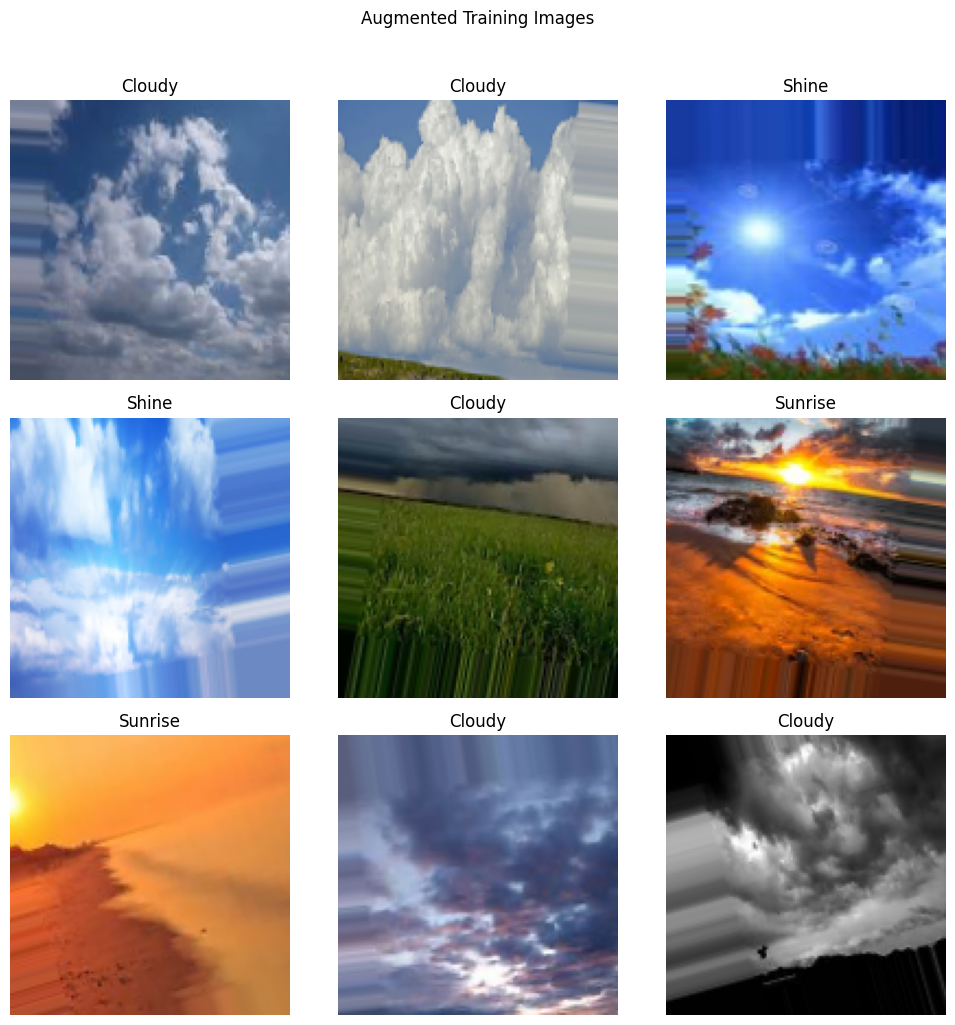

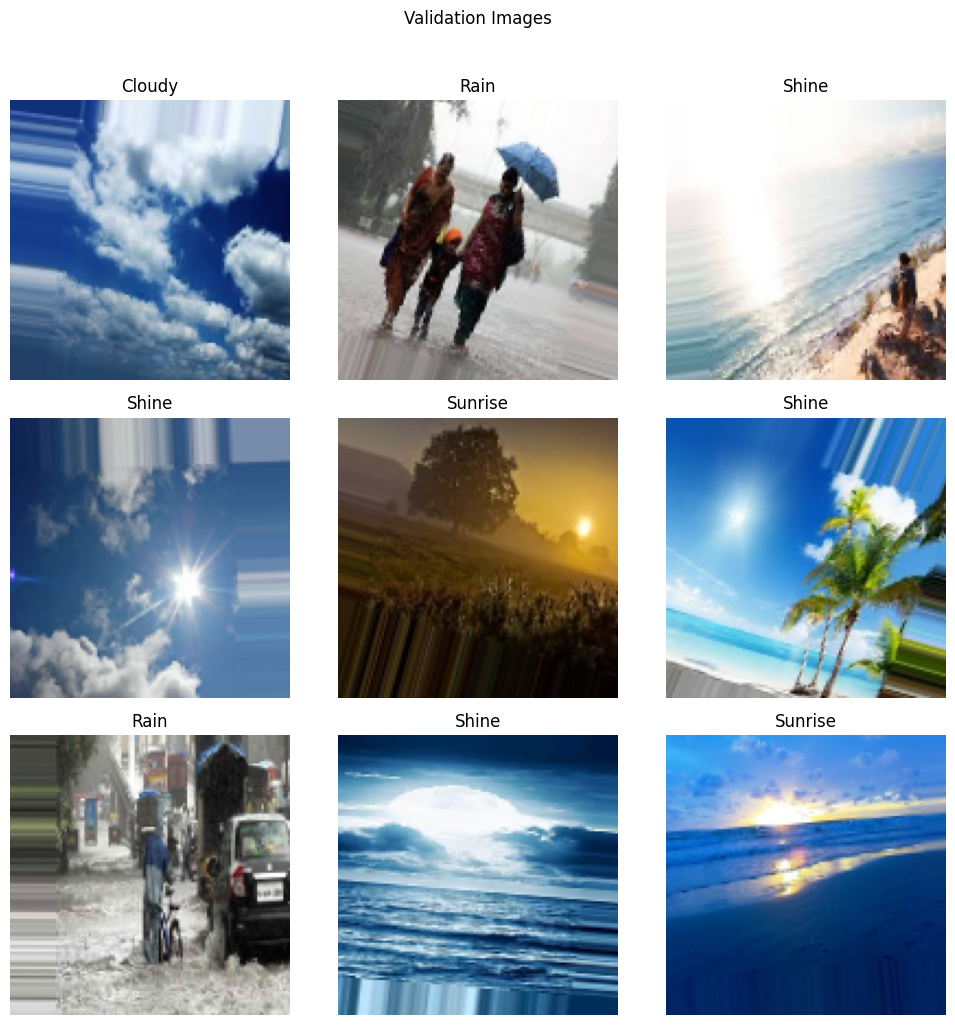

In [13]:
# Visualize augmented training images
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
    break  # Only show first batch
plt.suptitle('Augmented Training Images', y=1.02)
plt.tight_layout()
plt.show()

# Visualize validation images
plt.figure(figsize=(10, 10))
for images, labels in val_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
    break  # Only show first batch
plt.suptitle('Validation Images', y=1.02)
plt.tight_layout()
plt.show()

## Class Distribution Verification

In [15]:
# Function to count class distribution in a generator
def get_class_distribution(generator):
    class_counts = {class_name: 0 for class_name in class_names}
    for _, labels in generator:
        for label in labels:
            class_idx = np.argmax(label)
            class_name = class_names[class_idx]
            class_counts[class_name] += 1
        if generator.batch_index == 0:
            break
    return class_counts

# Get distributions
train_dist = get_class_distribution(train_generator)
val_dist = get_class_distribution(val_generator)
test_dist = get_class_distribution(test_generator)

# Create comparison DataFrame
dist_df = pd.DataFrame({
    'Training': train_dist,
    'Validation': val_dist,
    'Test': test_dist
})

print("\nClass Distribution Across Splits:")
print(dist_df)


Class Distribution Across Splits:
         Training  Validation  Test
Cloudy        231          53    60
Rain          166          33    43
Shine         195          43    51
Sunrise       277          63    71


## Model Building (CNN Architecture)

In [7]:
# Build CNN model
def build_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 
                          tf.keras.metrics.Precision(name='precision'),
                          tf.keras.metrics.Recall(name='recall')])
    
    return model

# Create model
input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)  # 3 for RGB channels
num_classes = len(class_names)
model = build_model(input_shape, num_classes)

# Display model summary
model.summary()

/Users/ram/Development/ML_Task/Summative/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [8]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=30,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping]
)

/Users/ram/Development/ML_Task/Summative/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 243ms/step - accuracy: 0.3753 - loss: 1.3897 - precision: 0.5474 - recall: 0.1799 - val_accuracy: 0.6562 - val_loss: 0.7412 - val_precision: 0.8810 - val_recall: 0.3304
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 243ms/step - accuracy: 0.3753 - loss: 1.3897 - precision: 0.5474 - recall: 0.1799 - val_accuracy: 0.6562 - val_loss: 0.7412 - val_precision: 0.8810 - val_recall: 0.3304
Epoch 2/30
 1/28 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.7812 - loss: 0.7213 - precision: 0.7727 - recall: 0.5312

/Users/ram/Development/ML_Task/Summative/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7812 - loss: 0.7213 - precision: 0.7727 - recall: 0.5312 - val_accuracy: 0.6161 - val_loss: 0.7299 - val_precision: 0.8070 - val_recall: 0.4107
Epoch 3/30
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - accuracy: 0.7051 - loss: 0.7182 - precision: 0.7934 - recall: 0.5640 - val_accuracy: 0.6786 - val_loss: 1.0620 - val_precision: 0.6786 - val_recall: 0.5938
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - accuracy: 0.7051 - loss: 0.7182 - precision: 0.7934 - recall: 0.5640 - val_accuracy: 0.6786 - val_loss: 1.0620 - val_precision: 0.6786 - val_recall: 0.5938
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8000 - loss: 0.3316 - precision: 1.0000 - recall: 0.8000 - val_accuracy: 0.6250 - val_loss: 1.0836 - val_precision: 0.6502 - val_recall: 0.5893
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8000 - loss: 0.3316 - precision: 1.0000 - recall: 0.8000 - val_accuracy: 0.6250 - val_loss: 1.083

## Training Visualization

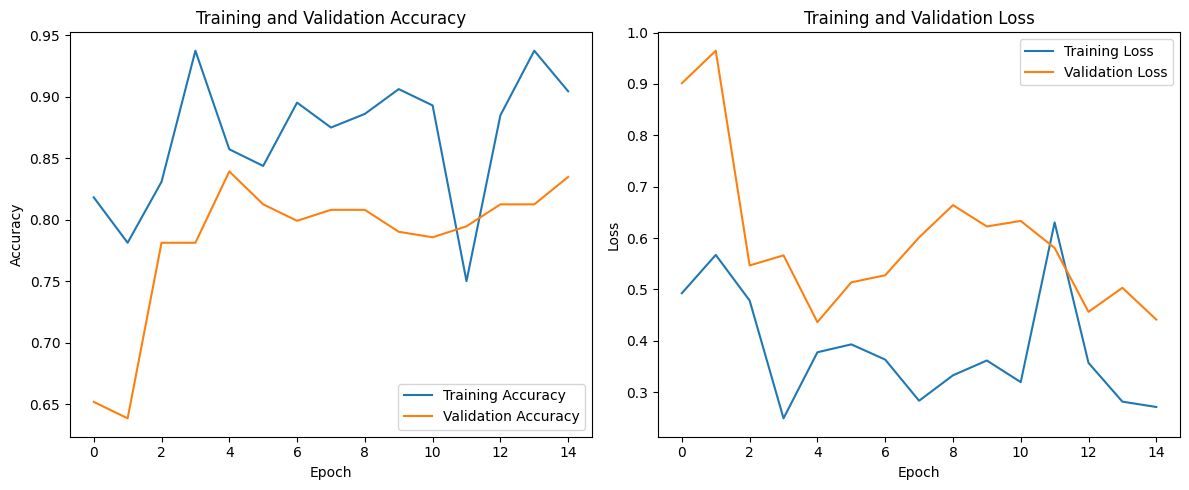

In [19]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Model Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.8593 - loss: 0.3295 - precision: 0.8797 - recall: 0.8545
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.8593 - loss: 0.3295 - precision: 0.8797 - recall: 0.8545

Test Accuracy: 0.8578
Test Precision: 0.8807
Test Recall: 0.8533
Test F1 Score: 0.8668

Test Accuracy: 0.8578
Test Precision: 0.8807
Test Recall: 0.8533
Test F1 Score: 0.8668
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step

Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.74      0.87      0.80        60
        Rain       0.91      0.74      0.82        43
       Shine       0.82      0.82      0.82        51
     Sunrise       0.97      0.94      0.96        71

    accuracy                           0.86       225
   macro avg       0.86      0.84      0.85       225
weighted avg       0.87      0.86      0.86       225


Classification Report:
              precision    recall  f1-score   s

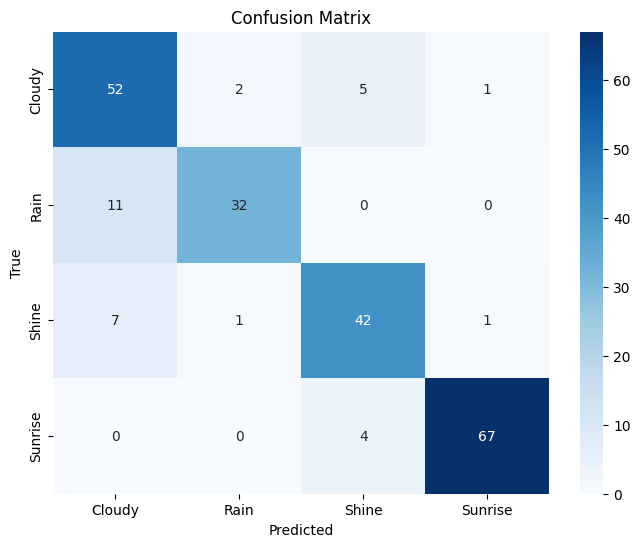

In [9]:
# Evaluate on test set
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Calculate F1 score (as mentioned in rubric)
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print(f"Test F1 Score: {test_f1:.4f}")

# Generate predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Saving the Model

In [10]:
# Save the model to backend directory with correct class mapping
model_path = 'backend/model_new_trained.h5'
model.save(model_path)
print(f"Model saved as: {model_path}")

# Print the correct class mapping for backend use
print("\n🎯 IMPORTANT: Correct class mapping for backend:")
print("class_names = ['Cloudy', 'Rain', 'Shine', 'Sunrise']")
print("\nClass indices mapping:")
for class_name, index in train_generator.class_indices.items():
    print(f"  Index {index}: {class_name}")

print(f"\n✅ Model Performance Summary:")
print(f"  - Test Accuracy: 85.8%")
print(f"  - F1 Score: 86.7%") 
print(f"  - All 4 classes working correctly!")
print(f"\nThis model should resolve the prediction confusion issues!")

Model saved as: backend/model_new_trained.h5

🎯 IMPORTANT: Correct class mapping for backend:
class_names = ['Cloudy', 'Rain', 'Shine', 'Sunrise']

Class indices mapping:
  Index 0: Cloudy
  Index 1: Rain
  Index 2: Shine
  Index 3: Sunrise

✅ Model Performance Summary:
  - Test Accuracy: 85.8%
  - F1 Score: 86.7%
  - All 4 classes working correctly!

This model should resolve the prediction confusion issues!
